In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/beijing/Beijing.csv


In [35]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)


OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [ ]:
# 1. Improved Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.losses import Huber

def preprocess_data(data_path, sequence_length=24):
    """
    Enhanced preprocessing pipeline
    """
    # Load data
    data = pd.read_csv(data_path)
    data.drop(['No', 'station'], axis=1, inplace=True)
    
    #first 100000 data
#   data = data[:100000]
    
    # Create datetime index
    data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
    data.set_index('datetime', inplace=True)
    # Handle missing values before any transformations
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].interpolate(method='time')
    

    
    # Check for and remove outliers
    def remove_outliers(df, columns, n_std=3):
        for col in columns:
            mean = df[col].mean()
            std = df[col].std()
            df.loc[df[col] > mean + (n_std * std), col] = mean + (n_std * std)
            df.loc[df[col] < mean - (n_std * std), col] = mean - (n_std * std)
        return df
    
    data = remove_outliers(data, ['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'])
    
    # Enhanced feature engineering
    # 1. Wind direction encoding using cyclic features
    data = pd.get_dummies(data, columns=['wd'], drop_first=True)
    
    # 2. Time-based features
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # 3. Cyclical encoding of time features
    def create_cyclical_features(df, col, period):
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/period)
        return df
    
    data = create_cyclical_features(data, 'hour', 24)
    data = create_cyclical_features(data, 'dayofweek', 7)
    data = create_cyclical_features(data, 'month', 12)
    
    # 4. Lag features
    for lag in [1, 3, 6, 12, 24]:
        data[f'pm25_lag_{lag}'] = data['PM2.5'].shift(lag)
    
    # 5. Rolling statistics
    for window in [6, 12, 24]:
        data[f'pm25_roll_mean_{window}'] = data['PM2.5'].rolling(window=window).mean()
        data[f'pm25_roll_std_{window}'] = data['PM2.5'].rolling(window=window).std()
    
    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    # Scale features
    scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
    
    # Create sequences
    X, y = [], []
    target_column_index = list(data.columns).index('PM2.5')
    
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length, target_column_index])
    
    X, y = np.array(X), np.array(y)
    
    # Split data with consideration for time series
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    
    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, 
            scaler, data.columns, target_column_index)


#TWO LAYESR LSTM MODEL FOR COMPLEX DATA
import tensorflow as tf
from tensorflow.keras.losses import Huber

# Simplified LSTM model with two LSTM layers
def build_simplified_model(input_shape):
    """
    Simplified LSTM model with two LSTM layers and basic regularization
    """
    model = tf.keras.Sequential()

    # First LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=True,  
        input_shape=input_shape,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Second LSTM layer
    model.add(tf.keras.layers.LSTM(
        units=64,  
        return_sequences=False,  
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) 
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))  

    # Dense layer
    model.add(tf.keras.layers.Dense(32, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.2)) 
    
    # Output layer
    model.add(tf.keras.layers.Dense(1))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  
        loss=Huber(),
        metrics=['mae', 'mse']
    )

    return model


# Training and prediction pipeline
def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
    """
    Complete training and prediction pipeline
    """
    # Set up callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]

    # Build the simplified model with two LSTM layers
    model = build_simplified_model((X_train.shape[1], X_train.shape[2]))

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions
    def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
        dummy = np.zeros((len(predictions), len(data_columns)))
        dummy[:, target_column_index] = predictions.flatten()
        return scaler.inverse_transform(dummy)[:, target_column_index]

    predictions = model.predict(X_test)
    predictions_orig = inverse_transform_predictions(
        predictions, scaler, data_columns, target_column_index
    )
    y_test_orig = inverse_transform_predictions(
        y_test.reshape(-1, 1), scaler, data_columns, target_column_index
    )

    return model, history, predictions_orig, y_test_orig



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import joblib
import os

# First, save both the model and the scaler
def save_model_artifacts(model, scaler, base_path='/kaggle/working/'):
    """
    Save both the trained model and scaler
    """
    # Create directory if it doesn't exist
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    # Save model with .keras extension
    model_path = os.path.join(base_path, 'best_lstm_model.keras')
    model.save(model_path)
    
    # Save scaler
    scaler_path = os.path.join(base_path, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    
    print(f"Model saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")
    
    return model_path, scaler_path

def load_model_artifacts(base_path='/kaggle/working/'):
    """
    Load the saved model and scaler
    """
    model_path = os.path.join(base_path, 'best_lstm_model.keras')
    scaler_path = os.path.join(base_path, 'scaler.pkl')
    
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    return model, scaler


# def evaluate_predictions(y_true, y_pred, dates=None):
#     """
#     Comprehensive evaluation of predictions
#     """
#     metrics = {
#         'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
#         'MAE': mean_absolute_error(y_true, y_pred),
#         'R2': r2_score(y_true, y_pred),
#         'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
#         'Mean Bias Error': np.mean(y_pred - y_true),
#         'Max Error': np.max(np.abs(y_pred - y_true)),
#         'Error Std': np.std(y_pred - y_true)
#     }
    
#     # Create visualization plots
#     plt.figure(figsize=(20, 12))
    
#     # 1. Time Series Plot
#     plt.subplot(2, 2, 1)
#     if dates is not None:
#         plt.plot(dates[:200], y_true[:200], label='Actual', alpha=0.7)
#         plt.plot(dates[:200], y_pred[:200], label='Predicted', alpha=0.7)
#     else:
#         plt.plot(y_true[:200], label='Actual', alpha=0.7)
#         plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
#     plt.title('Time Series Plot (First 200 samples)')
#     plt.legend()
    
#     # 2. Scatter Plot
#     plt.subplot(2, 2, 2)
#     plt.scatter(y_true, y_pred, alpha=0.5)
#     plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predicted Values')
#     plt.title('Actual vs Predicted')
    
#     # 3. Error Distribution
#     plt.subplot(2, 2, 3)
#     errors = y_pred - y_true
#     sns.histplot(errors, kde=True)
#     plt.title('Error Distribution')
#     plt.xlabel('Prediction Error')
    
#     # 4. Residual Plot
#     plt.subplot(2, 2, 4)
#     plt.scatter(y_pred, errors, alpha=0.5)
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.xlabel('Predicted Values')
#     plt.ylabel('Residuals')
#     plt.title('Residual Plot')
    
#     plt.tight_layout()
#     plt.show()
#     return metrics

def evaluate_predictions(y_true, y_pred, dates=None):
    """
    Comprehensive evaluation of predictions with enhanced visualization and metrics display
    """
    # Compute Metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Mean Bias Error': np.mean(y_pred - y_true),
        'Max Error': np.max(np.abs(y_pred - y_true)),
        'Error Std': np.std(y_pred - y_true)
    }
    
    # Print metrics in a table format for better presentation
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
    print("\nEvaluation Metrics:")
    print(metrics_df.to_string(index=False))
    
    # Create Visualization Plots
    plt.figure(figsize=(20, 16))

    # 1. Time Series Plot (First 200 samples)
    plt.subplot(2, 2, 1)
    if dates is not None:
        plt.plot(dates[:200], y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(dates[:200], y_pred[:200], label='Predicted', color='r', alpha=0.7)
    else:
        plt.plot(y_true[:200], label='Actual', color='b', alpha=0.7)
        plt.plot(y_pred[:200], label='Predicted', color='r', alpha=0.7)
    plt.title('Time Series Plot (First 200 samples)', fontsize=14)
    plt.xlabel('Date' if dates is not None else 'Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # 2. Scatter Plot (Actual vs Predicted)
    plt.subplot(2, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.6, color='purple', edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Fit')
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title('Actual vs Predicted', fontsize=14)
    plt.legend()
    plt.grid(True)

    # 3. Error Distribution (Histogram)
    plt.subplot(2, 2, 3)
    errors = y_pred - y_true
    sns.histplot(errors, kde=True, color='green', bins=30)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.title('Error Distribution', fontsize=14)
    plt.xlabel('Prediction Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True)

    # 4. Residual Plot (Predicted vs Residuals)
    plt.subplot(2, 2, 4)
    residuals = y_pred - y_true
    plt.scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolors='k')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return metrics

In [4]:
# 1. First, preprocess your data
X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx = preprocess_data(
    "/kaggle/input/beijing/Beijing.csv", sequence_length=24
)

# 2. Train model and get predictions
model, history, predictions, actual = train_and_predict(
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, columns, target_idx
)

save_model_artifacts(model, scaler)

# 3. For new data predictions:
def predict_new_data(new_data, model, scaler, sequence_length):
    # Preprocess new data similarly
    processed_data = preprocess_data(new_data, sequence_length)
    # Make predictions
    predictions = model.predict(processed_data)
    # Inverse transform predictions
    return inverse_transform_predictions(predictions, scaler, columns, target_idx)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - loss: 0.0956 - mae: 0.2783 - mse: 0.1814 - val_loss: 0.0254 - val_mae: 0.1343 - val_mse: 0.0472 - learning_rate: 0.0010
Epoch 2/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0340 - mae: 0.1707 - mse: 0.0649 - val_loss: 0.0209 - val_mae: 0.1187 - val_mse: 0.0389 - learning_rate: 0.0010
Epoch 3/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.0318 - mae: 0.1653 - mse: 0.0611 - val_loss: 0.0248 - val_mae: 0.1516 - val_mse: 0.0469 - learning_rate: 0.0010
Epoch 4/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0303 - mae: 0.1612 - mse: 0.0582 - val_loss: 0.0197 - val_mae: 0.1138 - val_mse: 0.0370 - learning_rate: 0.0010
Epoch 5/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - loss: 0.0301 - mae: 0.1599 - mse: 0.0579 - val_loss: 0.0220 - val_mae: 0.1261 - val_mse: 0.0412 - learning_rate: 0.0010
Epoch 6/15
8437/8437 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0291 - mae: 0.1576 - mse: 0.0559 - val_loss: 0.023


Evaluation Metrics:
         Metric      Value
           RMSE  16.638915
            MAE   9.633649
             R2   0.952647
           MAPE  27.052837
Mean Bias Error  -0.054832
      Max Error 321.825753
      Error Std  16.638824


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


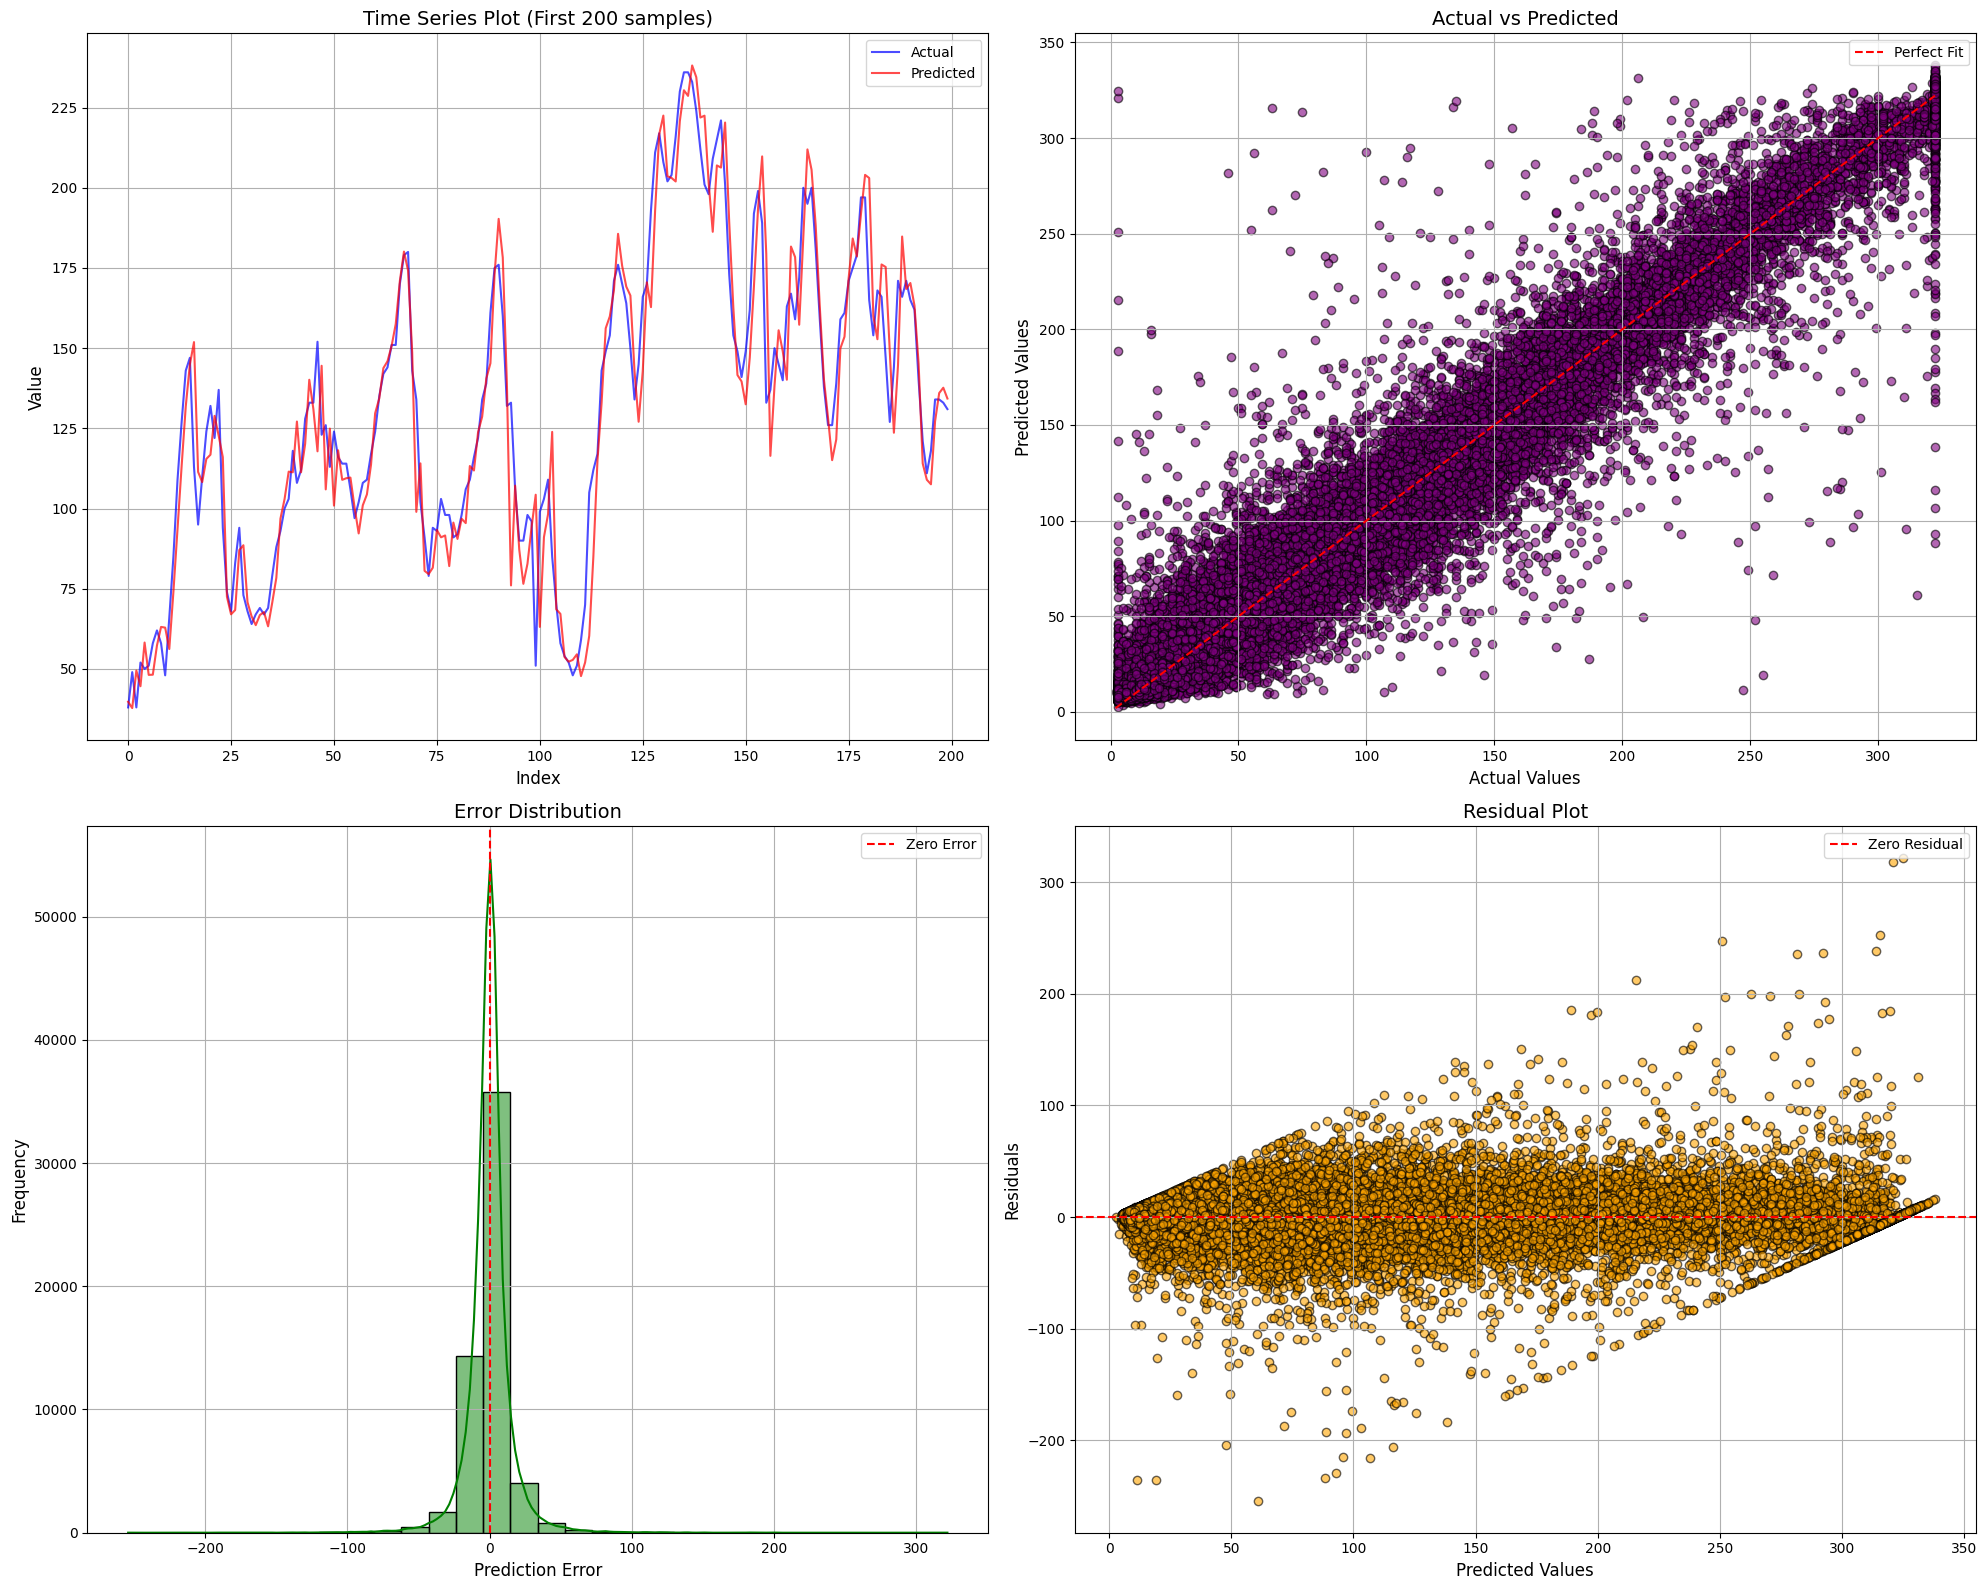

In [5]:
metrics = evaluate_predictions(actual, predictions)

In [5]:
X_train.shape

(69966, 24, 49)

In [18]:
X_train.shape

(69966, 24, 49)

In [16]:
check = pd.DataFrame(X_train[0])
check.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-1.0,-0.6,-0.933333,-0.916667,-0.441860,-0.584158,0.941176,-0.400912,-0.4,0.257576,...,-0.488372,-0.523256,-0.534884,-0.534884,-0.516,-0.511319,-0.577362,-0.596032,-0.671517,-0.757793
1,-1.0,-0.6,-0.933333,-0.833333,-0.430233,-0.613861,1.000000,-0.352132,-0.4,0.227273,...,-0.511628,-0.488372,-0.534884,-0.534884,-0.506,-0.458340,-0.568017,-0.580002,-0.666480,-0.748110
2,-1.0,-0.6,-0.933333,-0.750000,-0.418605,-0.623762,0.352941,0.574698,0.0,-0.287879,...,-0.488372,-0.476744,-0.465116,-0.534884,-0.496,-0.412426,-0.563863,-0.556057,-0.660884,-0.737681
3,-1.0,-0.6,-0.933333,-0.666667,-0.406977,-0.475248,0.941176,0.233234,0.4,-0.090909,...,-0.441860,-0.488372,-0.534884,-0.534884,-0.482,-0.388522,-0.552440,-0.543138,-0.654729,-0.726788
4,-1.0,-0.6,-0.933333,-0.583333,-0.406977,-0.534653,1.000000,0.940551,-0.4,-0.106061,...,-0.430233,-0.511628,-0.534884,-0.534884,-0.464,-0.459803,-0.541018,-0.543733,-0.648573,-0.718870


In [13]:
y_train.shape

(69966,)

In [ ]:
# 2. Improved Model Building
# def build_improved_model(hp, input_shape):
#     """
#     Enhanced LSTM model with better architecture
#     """
#     model = tf.keras.Sequential()
    
#     # First LSTM layer
#     model.add(tf.keras.layers.LSTM(
#         units=hp.Int('units_1', min_value=32, max_value=256, step=32),
#         return_sequences=True,
#         input_shape=input_shape,
#         kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', 1e-5, 1e-2, sampling='log'))
#     ))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
#     # Second LSTM layer
#     model.add(tf.keras.layers.LSTM(
#         units=hp.Int('units_2', min_value=16, max_value=128, step=16),
#         return_sequences=False
#     ))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    
#     # Dense layers
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
#         activation='relu'
#     ))
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1))
    
#     # Compile model with learning rate tuning
#     optimizer = tf.keras.optimizers.Adam(
#         hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
#     )

#     model.compile(
#         optimizer=optimizer,
#         loss=Huber(),
#         metrics=['mae', 'mse']
#     )
    
#     return model

# # 3. Training and Prediction Pipeline
# def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
#     """
#     Complete training and prediction pipeline
#     """
#     # Set up callbacks
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_loss',
#             factor=0.5,
#             patience=3,
#             min_lr=1e-6
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             'best_model.keras',
#             monitor='val_loss',
#             save_best_only=True
#         )
#     ]
    
#     # Initialize tuner
#     tuner = kt.Hyperband(
#         lambda hp: build_improved_model(hp, (X_train.shape[1], X_train.shape[2])),
#         objective=kt.Objective('val_loss', direction='min'),
#         max_epochs=30,
#         factor=3,
#         directory='lstm_tuning',
#         project_name='pm25_prediction'
#     )
    
#     # Search for best hyperparameters
#     tuner.search(
#         X_train, y_train,
#         epochs=20,
#         validation_data=(X_val, y_val),
#         callbacks=callbacks
#     )
    
#     # Get best model
#     best_hp = tuner.get_best_hyperparameters()[0]
#     model = tuner.hypermodel.build(best_hp)
    
#     # Train with best hyperparameters
#     history = model.fit(
#         X_train, y_train,
#         epochs=50,
#         batch_size=32,
#         validation_data=(X_val, y_val),
#         callbacks=callbacks,
#         verbose=1
#     )
    
#     # Make predictions
#     def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
#         dummy = np.zeros((len(predictions), len(data_columns)))
#         dummy[:, target_column_index] = predictions.flatten()
#         return scaler.inverse_transform(dummy)[:, target_column_index]
    
#     predictions = model.predict(X_test)
#     predictions_orig = inverse_transform_predictions(
#         predictions, scaler, data_columns, target_column_index
#     )
#     y_test_orig = inverse_transform_predictions(
#         y_test.reshape(-1, 1), scaler, data_columns, target_column_index
#     )
    
#     return model, history, predictions_orig, y_test_orig



#REDUCED EPOCHS
# def build_improved_model(hp, input_shape):
#     """
#     Enhanced LSTM model with better architecture
#     """
#     model = tf.keras.Sequential()
    
#     # First LSTM layer
#     model.add(tf.keras.layers.LSTM(
#         units=hp.Int('units_1', min_value=64, max_value=128, step=32),
#         return_sequences=True,
#         input_shape=input_shape,
#         kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', 1e-5, 1e-2, sampling='log'))
#     ))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', 0.2, 0.4, step=0.1)))
    
#     # Second LSTM layer
#     model.add(tf.keras.layers.LSTM(
#         units=hp.Int('units_2', min_value=16, max_value=128, step=16),
#         return_sequences=False
#     ))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    
#     # Dense layers
#     model.add(tf.keras.layers.Dense(
#         units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
#         activation='relu'
#     ))
#     model.add(tf.keras.layers.Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1)))
    
#     # Output layer
#     model.add(tf.keras.layers.Dense(1))
    
#     # Compile model with learning rate tuning
#     optimizer = tf.keras.optimizers.Adam(
#         hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
#     )

#     model.compile(
#         optimizer=optimizer,
#         loss=Huber(),
#         metrics=['mae', 'mse']
#     )
    
#     return model

# # 3. Training and Prediction Pipeline
# def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
#     """
#     Complete training and prediction pipeline
#     """
#     # Set up callbacks
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_loss',
#             factor=0.5,
#             patience=3,
#             min_lr=1e-6
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             'best_model.keras',
#             monitor='val_loss',
#             save_best_only=True
#         )
#     ]
    
#     # Initialize tuner
#     tuner = kt.Hyperband(
#         lambda hp: build_improved_model(hp, (X_train.shape[1], X_train.shape[2])),
#         objective=kt.Objective('val_loss', direction='min'),
#         max_epochs=15,
#         factor=2,
#         directory='lstm_tuning',
#         project_name='pm25_prediction'
#     )
    
#     # Search for best hyperparameters
#     tuner.search(
#         X_train, y_train,
#         epochs=5,
#         validation_data=(X_val, y_val),
#         callbacks=callbacks
#     )
    
#     # Get best model
#     best_hp = tuner.get_best_hyperparameters()[0]
#     model = tuner.hypermodel.build(best_hp)
    
#     # Train with best hyperparameters
#     history = model.fit(
#         X_train, y_train,
#         epochs=15,
#         batch_size=32,
#         validation_data=(X_val, y_val),
#         callbacks=callbacks,
#         verbose=1
#     )
    
#     # Make predictions
#     def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
#         dummy = np.zeros((len(predictions), len(data_columns)))
#         dummy[:, target_column_index] = predictions.flatten()
#         return scaler.inverse_transform(dummy)[:, target_column_index]
    
#     predictions = model.predict(X_test)
#     predictions_orig = inverse_transform_predictions(
#         predictions, scaler, data_columns, target_column_index
#     )
#     y_test_orig = inverse_transform_predictions(
#         y_test.reshape(-1, 1), scaler, data_columns, target_column_index
#     )
    
#     return model, history, predictions_orig, y_test_orig


#ONE LAYER WITH NO HYPERPARAMETER TUNING
# import tensorflow as tf
# from tensorflow.keras.losses import Huber

# # Simplified LSTM model with one layer
# def build_simplified_model(input_shape):
#     """
#     Simplified LSTM model with one LSTM layer and basic regularization
#     """
#     model = tf.keras.Sequential()

#     # LSTM layer
#     model.add(tf.keras.layers.LSTM(
#         units=64,  # Fixed number of units
#         return_sequences=False,  # Only the last output is returned
#         input_shape=input_shape,
#         kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 regularization
#     ))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dropout(0.2))  # Fixed dropout rate

#     # Dense layer
#     model.add(tf.keras.layers.Dense(32, activation='relu'))  # Fixed dense units
#     model.add(tf.keras.layers.Dropout(0.2))  # Fixed dropout rate

#     # Output layer
#     model.add(tf.keras.layers.Dense(1))

#     # Compile model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Fixed learning rate
#         loss=Huber(),
#         metrics=['mae', 'mse']
#     )

#     return model


# # Training and prediction pipeline
# def train_and_predict(X_train, X_val, X_test, y_train, y_val, y_test, scaler, data_columns, target_column_index):
#     """
#     Complete training and prediction pipeline
#     """
#     # Set up callbacks
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_loss',
#             factor=0.5,
#             patience=3,
#             min_lr=1e-6
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             'best_model.keras',
#             monitor='val_loss',
#             save_best_only=True
#         )
#     ]

#     # Build the simplified model
#     model = build_simplified_model((X_train.shape[1], X_train.shape[2]))

#     # Train the model
#     history = model.fit(
#         X_train, y_train,
#         epochs=15,
#         batch_size=32,
#         validation_data=(X_val, y_val),
#         callbacks=callbacks,
#         verbose=1
#     )

#     # Make predictions
#     def inverse_transform_predictions(predictions, scaler, data_columns, target_column_index):
#         dummy = np.zeros((len(predictions), len(data_columns)))
#         dummy[:, target_column_index] = predictions.flatten()
#         return scaler.inverse_transform(dummy)[:, target_column_index]

#     predictions = model.predict(X_test)
#     predictions_orig = inverse_transform_predictions(
#         predictions, scaler, data_columns, target_column_index
#     )
#     y_test_orig = inverse_transform_predictions(
#         y_test.reshape(-1, 1), scaler, data_columns, target_column_index
#     )

#     return model, history, predictions_orig, y_test_orig
